In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [585]:
prescrip = pd.read_csv('PRESCRIPTIONS.csv')

admiss = pd.read_csv('ADMISSIONS.csv')
admiss = admiss.drop(columns=["ROW_ID", "HADM_ID", "HAS_CHARTEVENTS_DATA","EDREGTIME", "DEATHTIME",
                              "ADMITTIME","DISCHTIME", "EDOUTTIME","ADMISSION_LOCATION","DISCHARGE_LOCATION",
                              "DIAGNOSIS","HOSPITAL_EXPIRE_FLAG"])

In [586]:
list(prescrip)

['row_id',
 'subject_id',
 'hadm_id',
 'icustay_id',
 'startdate',
 'enddate',
 'drug_type',
 'drug',
 'drug_name_poe',
 'drug_name_generic',
 'formulary_drug_cd',
 'gsn',
 'ndc',
 'prod_strength',
 'dose_val_rx',
 'dose_unit_rx',
 'form_val_disp',
 'form_unit_disp',
 'route']

In [532]:
prescrip = prescrip.drop(columns=['drug_type', 'hadm_id', 'icustay_id', 'row_id', 'drug_name_generic',
                                  'formulary_drug_cd', 'gsn', 'ndc','form_val_disp', 'form_unit_disp', 
                                  'route', 'drug_name_poe','prod_strength'])
list(prescrip)

['subject_id', 'startdate', 'enddate', 'drug', 'dose_val_rx', 'dose_unit_rx']

In [533]:
print('Dataset has {} number of unique drugs.'.format(prescrip['drug'].nunique()))

Dataset has 592 number of unique drugs.


In [534]:
prescrip['startdate'] = pd.to_datetime(prescrip['startdate'])
prescrip['enddate'] = pd.to_datetime(prescrip['enddate'])
# Convert timedelta type into float 'days', 86400 seconds in a day (USED FROM LECTURE)
prescrip['prescrip_time'] = (prescrip['enddate'] - prescrip['startdate']).dt.total_seconds()/86400

In [535]:
prescrip[['startdate', 'enddate', 'prescrip_time']].head()

,startdate,enddate,prescrip_time
0,2146-07-21,2146-07-22,1.0
1,2146-07-21,2146-07-22,1.0
2,2146-07-21,2146-07-22,1.0
3,2146-07-21,2146-07-22,1.0
4,2146-07-21,2146-07-21,0.0


In [536]:
prescrip['prescrip_time'].describe()

count    10397.000000
mean         3.044340
std          7.119632
min        -17.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        103.000000
Name: prescrip_time, dtype: float64

In [537]:
print("Less than 0: {} times".format((prescrip['prescrip_time'] < 0).sum()))

prescrip[prescrip['prescrip_time'] < 0].head()

Less than 0: 39 times


,subject_id,startdate,enddate,drug,dose_val_rx,dose_unit_rx,prescrip_time
1252,10124,2192-04-27,2192-04-26,Sodium Chloride 0.9% Flush,3,ml,-1.0
1450,10111,2180-01-23,2180-01-22,Prednisone,40,mg,-1.0
1451,10111,2180-01-24,2180-01-22,Prednisone,30,mg,-2.0
1624,40601,2184-08-11,2184-08-10,Lisinopril,5,mg,-1.0
1885,41795,2145-09-10,2145-09-09,PredniSONE,50,mg,-1.0


In [538]:
prescrip['prescrip_time'][prescrip['prescrip_time'] > 0].describe()

count    8087.000000
mean        3.927909
std         7.845725
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       103.000000
Name: prescrip_time, dtype: float64

In [539]:
prescrip['dose_unit_rx'].value_counts()

dose_unit_rx
mg               4378
mL               1849
ml               1216
mEq               670
UNIT              588
gm                488
TAB               174
NEB               153
g                 148
mcg               140
VIAL               75
Appl               71
PUFF               64
mmol               63
PKT                56
DROP               53
BAG                31
SYR                28
mcg/hr             27
CAP                25
PTCH               22
mg PE              14
INH                12
in                 10
AMP                10
LOZ                 7
SPRY                6
million units       4
dose                4
TROC                4
gtt                 2
mcg/h               2
UDCUP               2
L                   1
Enema               1
Name: count, dtype: int64

In [540]:
prescrip['dose_unit_rx'] = prescrip['dose_unit_rx'][(prescrip['dose_unit_rx'] == 'ml') | (prescrip['dose_unit_rx'] == 'mL')]

prescrip['dose_unit_rx'].value_counts()

dose_unit_rx
mL    1849
ml    1216
Name: count, dtype: int64

In [541]:
print(prescrip['drug'].value_counts().nlargest(10))
prescrip = prescrip[prescrip['drug'] == 'D5W']

drug
Potassium Chloride      529
D5W                     439
0.9% Sodium Chloride    409
NS                      362
Furosemide              346
Insulin                 300
Iso-Osmotic Dextrose    265
5% Dextrose             256
SW                      244
Magnesium Sulfate       206
Name: count, dtype: int64


In [546]:
prescrip['dose_val_rx'] = prescrip['dose_val_rx'].astype(float)

In [547]:
prescrip['dose_val_rx'].describe()

count     439.000000
mean      296.776765
std       330.660278
min        25.000000
25%       100.000000
50%       250.000000
75%       250.000000
max      3000.000000
Name: dose_val_rx, dtype: float64

In [548]:
prescrip = prescrip.drop(columns=['dose_unit_rx', 'startdate', 'enddate'])

In [549]:
admiss['subject_id'] = admiss['SUBJECT_ID']
admiss = admiss.drop(columns=['SUBJECT_ID'])

In [504]:
df = pd.merge(prescrip, admiss, on='subject_id', how='inner')

In [550]:
list(df)

['subject_id',
 'drug',
 'dose_val_rx',
 'prescrip_time',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY']

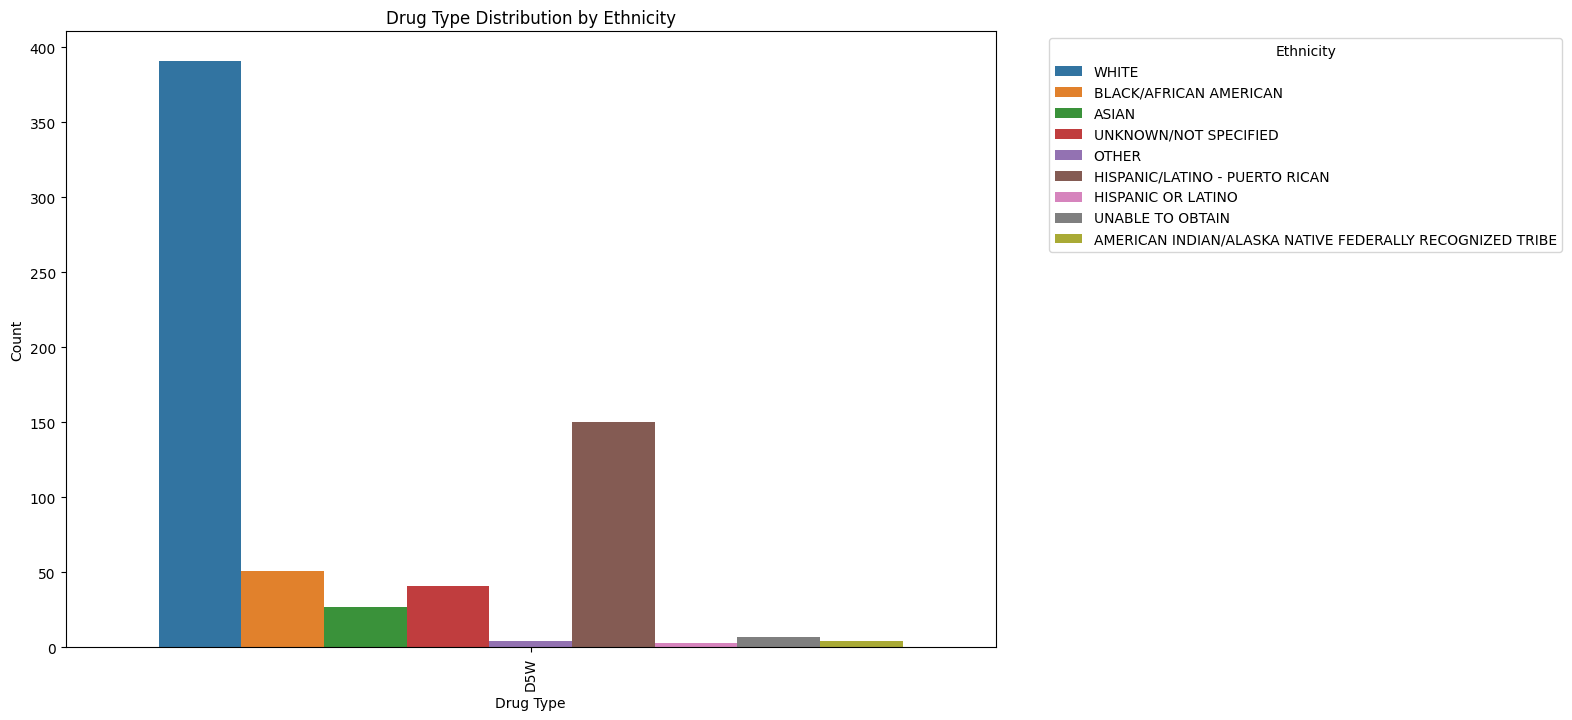

In [506]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='drug', hue='ETHNICITY', order=df['drug'].value_counts().head(15).index)
plt.title('Drug Type Distribution by Ethnicity')
plt.xticks(rotation=90)
plt.xlabel('Drug Type')
plt.ylabel('Count')
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# Compress the number of ethnicity categories (USED FROM LECTURE)
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

ETHNICITY
WHITE                     391
HISPANIC/LATINO           153
OTHER/UNKNOWN              56
BLACK/AFRICAN AMERICAN     51
ASIAN                      27
Name: count, dtype: int64

In [553]:
print(df['RELIGION'].value_counts())
# Condense all unkown or unobtainable values
# to this unknown tag. 
df['RELIGION'].replace(['UNOBTAINABLE', 'NOT SPECIFIED', 'OTHER'], 
                       value='OTHER/UNKNOWN', inplace=True)
print("\nAFTER:")
print(df['RELIGION'].value_counts())

RELIGION
CATHOLIC               309
OTHER/UNKNOWN          258
JEWISH                  72
PROTESTANT QUAKER       30
CHRISTIAN SCIENTIST      4
MUSLIM                   4
BUDDHIST                 1
Name: count, dtype: int64

AFTER:
RELIGION
CATHOLIC               309
OTHER/UNKNOWN          258
JEWISH                  72
PROTESTANT QUAKER       30
CHRISTIAN SCIENTIST      4
MUSLIM                   4
BUDDHIST                 1
Name: count, dtype: int64


In [554]:
print(df['INSURANCE'].value_counts())
df['INSURANCE'] = df['INSURANCE'][df['INSURANCE'] != 'Government']
print("\nAFTER:")
df['INSURANCE'].value_counts()

INSURANCE
Medicare    552
Private      98
Medicaid     27
Name: count, dtype: int64

AFTER:


INSURANCE
Medicare    552
Private      98
Medicaid     27
Name: count, dtype: int64

In [555]:
print(df['MARITAL_STATUS'].value_counts())
df['MARITAL_STATUS'].replace(['DIVORCED', 'SEPARATED'], value='DIVORCED', inplace=True)
print("\nAFTER:")
print(df['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED              338
SINGLE                95
WIDOWED               88
UNKNOWN (DEFAULT)     46
DIVORCED              31
Name: count, dtype: int64

AFTER:
MARITAL_STATUS
MARRIED              338
SINGLE                95
WIDOWED               88
UNKNOWN (DEFAULT)     46
DIVORCED              31
Name: count, dtype: int64


In [556]:
print(df['INSURANCE'].value_counts())

print(df['LANGUAGE'].value_counts())

print(df['ADMISSION_TYPE'].value_counts())

INSURANCE
Medicare    552
Private      98
Medicaid     27
Name: count, dtype: int64
LANGUAGE
SPAN    150
ENGL    129
RUSS     32
MAND     26
Name: count, dtype: int64
ADMISSION_TYPE
EMERGENCY    665
ELECTIVE      11
URGENT         2
Name: count, dtype: int64


In [557]:
list(df)

['subject_id',
 'drug',
 'dose_val_rx',
 'prescrip_time',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY']

In [558]:
encoded_df = df.drop(columns=['subject_id', 'drug', 'prescrip_time'])


encoded_df = pd.get_dummies(encoded_df, columns=['ADMISSION_TYPE', 'INSURANCE',
                                                'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY'])


In [559]:
list(encoded_df)

['dose_val_rx',
 'ADMISSION_TYPE_ELECTIVE',
 'ADMISSION_TYPE_EMERGENCY',
 'ADMISSION_TYPE_URGENT',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'LANGUAGE_ENGL',
 'LANGUAGE_MAND',
 'LANGUAGE_RUSS',
 'LANGUAGE_SPAN',
 'RELIGION_BUDDHIST',
 'RELIGION_CATHOLIC',
 'RELIGION_CHRISTIAN SCIENTIST',
 'RELIGION_JEWISH',
 'RELIGION_MUSLIM',
 'RELIGION_OTHER/UNKNOWN',
 'RELIGION_PROTESTANT QUAKER',
 'MARITAL_STATUS_DIVORCED',
 'MARITAL_STATUS_MARRIED',
 'MARITAL_STATUS_SINGLE',
 'MARITAL_STATUS_UNKNOWN (DEFAULT)',
 'MARITAL_STATUS_WIDOWED',
 'ETHNICITY_ASIAN',
 'ETHNICITY_BLACK/AFRICAN AMERICAN',
 'ETHNICITY_HISPANIC/LATINO',
 'ETHNICITY_OTHER/UNKNOWN',
 'ETHNICITY_WHITE']

In [560]:
encoded_df.dropna(inplace=True)
dose = encoded_df['dose_val_rx']
features = encoded_df.drop(columns=['dose_val_rx'])

In [562]:
# Split into train 80% and test 20% (USED FROM LECTURE!)
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    dose,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 542 samples.
Testing set has 136 samples.


In [566]:
#USED FROM LECTURE
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
KNeighborsRegressor done.
RandomForestRegressor done.


In [567]:
print(results)

{'SGDRegressor': 0.018197901106408287, 'GradientBoostingRegressor': 0.0419978879960724, 'KNeighborsRegressor': -0.11780238440164337, 'RandomForestRegressor': 0.03325955161368188}


Text(0.5, 1.0, 'Comparison of Regression Models')

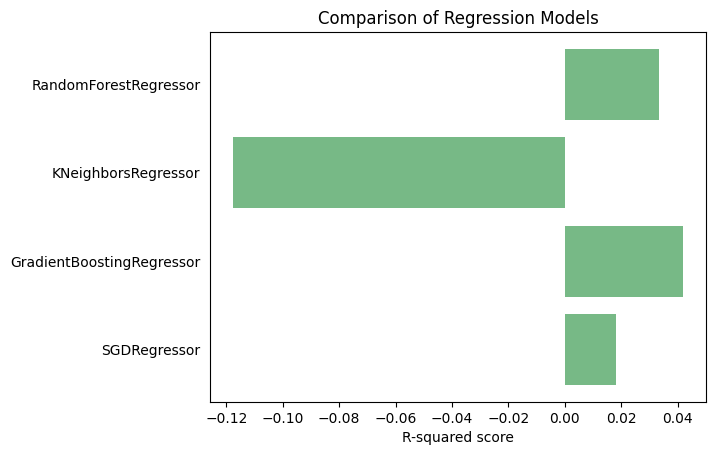

In [568]:
# R2 score results (USED FROM LECTURE)
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
#USED FROM LECTURE
reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.041998


In [584]:
#USED FROM LECTURE

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    dose,
                                                    test_size = .20,
                                                    random_state = 42)

# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]
tuned_parameters = [{'n_estimators': [10,20,30,40,50,60,70,80,90,100,200,300],
                     'max_depth' : [1,2,3,4,5],
                     'loss': ['squared_error', 'absolute_error']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

-0.0030166755084581665
GradientBoostingRegressor(max_depth=2, n_estimators=10)
